In [1]:
import os
import sys

import cv2
import random
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm

from transformers import SamModel, SamProcessor
from peft import get_peft_model, LoraConfig, TaskType


sys.path.append(os.path.abspath('/home/dmatveev/workdir/rosneft_segmentation/experiments'))

from prepare_data import SegmentationDataset, SeismicDataset

/home/dmatveev/workdir/rosneft_segmentation/for_rosneft/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: cannot import name 'SeismicDataset' from 'prepare_data' (/home/dmatveev/workdir/rosneft_segmentation/experiments/prepare_data.py)

In [10]:
train_config = {
    "model": {
        "pretrained": "facebook/sam-vit-huge", 
        "use_lora": True,
        "lora_config": { 
            "r": 64,
            "lora_alpha": 64,
            "target_modules": ["q_proj", "k_proj", "v_proj", "out_proj"],
            "lora_dropout": 0.1,
            "bias": "none",
            "task_type": "FEATURE_EXTRACTION"
        },
        "freeze_base": True
    },
    "training": {
        "epochs": 2,
        "batch_size": 1,
        "lr": 1e-4,
        "num_workers": 2,
        "log_interval": 10,
        "use_mask": True 
    },
    "data": {
        "type": "2D",
        "seismic_dir": "/home/dmatveev/workdir/rosneft_segmentation/data/paleokart/seismic",
        "label_dir": "/home/dmatveev/workdir/rosneft_segmentation/data/paleokart/label",
        "shape": (256, 256),
        "mask_dtype": np.uint8
    },
    "clearml": {
        "project_name": "SAM Fine Tuning",
        "task_name": "LoRA Training"
    }
}

# task.connect(train_config)

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = SamModel.from_pretrained(train_config["model"]["pretrained"]).to(device)
processor = SamProcessor.from_pretrained(train_config["model"]["pretrained"])
model.eval()

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-31): 32 x SamVisionLayer(
        (layer_norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (layer_norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNor

In [2]:
def load_dat_file(filepath, shape=(224, 224)):
    data = np.fromfile(filepath, dtype=np.float32)
    return data.reshape(shape)

In [5]:
test_file = load_dat_file("/home/dmatveev/workdir/rosneft_segmentation/data/test_data/seismic/seismic_slice_0.dat", shape=(400, 401))

In [4]:
test_label = load_dat_file("/home/dmatveev/workdir/rosneft_segmentation/data/test_data/label/label_slice_0.dat", shape=(400, 401))

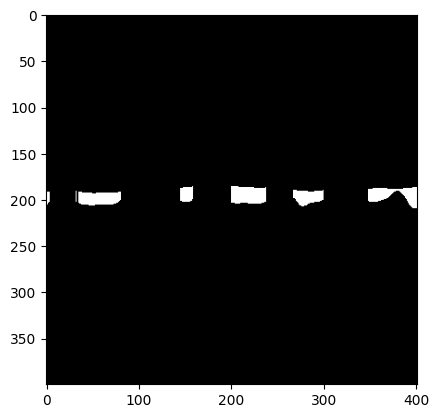

In [6]:
plt.imshow(test_label, cmap='gray')
plt.show()

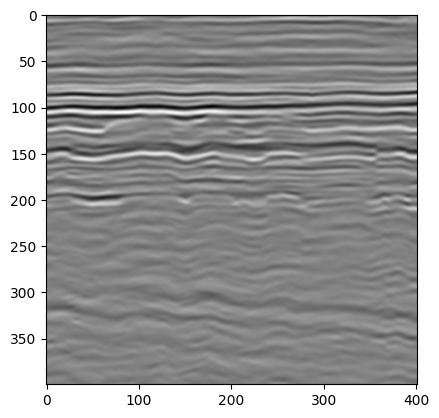

In [7]:
plt.imshow(test_file, cmap='gray')
plt.show()

In [13]:
test_file = np.stack([test_file, test_file, test_file], axis=-1)

In [14]:
inputs = processor(test_file, return_tensors="pt")

ValueError: The image to be converted to a PIL image contains values outside the range [0, 1], got [-8982.2880859375, 8618.1416015625] which cannot be converted to uint8.

In [7]:
tensor_data = torch.from_numpy(test_file).float().to(device)
tensor_data = tensor_data.unsqueeze(0).unsqueeze(0)
tensor_data = tensor_data.repeat(1, 3, 1, 1)
tensor_resized = F.interpolate(tensor_data, size=(1024, 1024), mode='bilinear', align_corners=False)

In [8]:
tensor_data.shape

torch.Size([1, 3, 400, 401])

In [9]:
outputs = model(tensor_resized)

In [16]:
outputs.pred_masks.shape

torch.Size([1, 1, 3, 256, 256])

In [17]:
pred_logits = outputs.pred_masks[:, 0, 1, :, :]  # Результат имеет форму [B, 256, 256]


In [18]:
pred_probs = torch.sigmoid(pred_logits[0])
# Применяем порог, чтобы получить бинарную маску
pred_mask = (pred_probs > 0.5).float()

In [19]:
pred_mask

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 1., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 1., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 1.]], device='cuda:0')

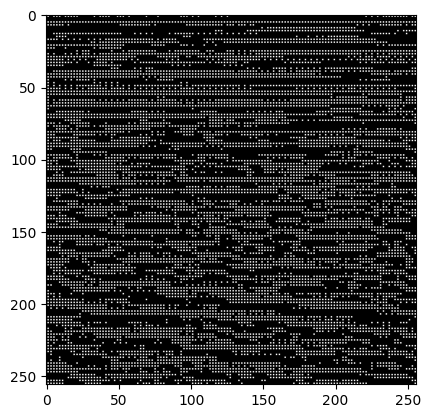

In [22]:
plt.imshow(pred_mask.cpu(), cmap='gray')
plt.show()